<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT22/blob/PeterTKovacs_lab4/PeterTKovacs_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lab 4: function approximation**


**Péter Kovács**

# **Abstract**

In this lab assignment, we deal with projection methods for function approximation.

First, a linear piecewise approximation is computed, then we apply the FEM method to estimate the solution of the Poisson-equation.

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [ ]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2022 Péter Kovács (ptkovacs@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [1]:
# Load neccessary modules.
from google.colab import files
import numpy as np
from scipy import integrate
import theano
import theano.tensor as tt


# **Introduction**

Projection methods are an useful tool to estimate functions over a finite basis. Since the method is conceptually the same as projections for any vector space, we won't spend much time on describing the details which can be found in the course materials or any standard textbook.

The main point of FEM is to reduce the estimation of the solution of PDEs to solving a system of linear equations. The general formulation of problem:

a(u,v)=L(v)

where **u** is the solution and **v** is an abitrary vector from the $V$ Sobolev-space associated with the problem. Symbols a(.,.) and L(.) stand for bilinear and linear forms respectively.

In FEM, we want to approximate the true **u** solution by some **U** lying in a finite dimensional $V_N$ subspace of $V$. To achieve this, we only require the weak form of the PDE to hold for test functions from $V_N$. So then it follows, that if a(.,.) is appropriate to define an inner product on $V$, the FEM method is in fact an orthogonal projection method to $V_N$ wrt. that inner product!

(And also, the solvability of the system of linear equations is then guaranteed by the Riesz representation theorem, so it is indeed crucial to be able to associate an inner product with a(.,.))




# **Method**

Since we will use it in multiple contexts, I first implement a general assembly algorithm, similar to algorithm 9.2, with sufficient flexibility and then apply it to projecton. Later, a slightly modified version will be used for the Poisson part, because there, one needs to enforce continuity due to the nature of the bilinear form)

### 0) Assembly and utilities

Below I implement the assembly algorithm and auxiliary functions - code speaks for itself.

I will rely on the scipy package to perform integrals.

To avoid super-ugly code, I implement the 1D element class whose member functions will do the weight-lifting for the assembly



In [2]:
class lagrange_1d_element:
  def __init__(self,x0,x1,order):

    self.order=order
    self.x0=x0
    self.x1=x1
    

    self.nodes=np.linspace(x0,x1,order+1) # support points for Lagrange basis
    self.n=self.nodes.shape[0]

  def local_shape(self,k,x): # implements the Lagrange nodal basis

    denominator=1.
    numerator=1.

    if(x<self.x0 or x>=self.x1):
      return 0.

    for i in range(self.n):
      if i!=k:
        denominator*=self.nodes[k]-self.nodes[i]
        numerator*=x-self.nodes[i]

    return numerator/denominator

  def get_local_shape_no(self):
    return self.n

  def integrate_matrix(self,i,j):
    f_i=lambda x: self.local_shape(i,x)
    f_j=lambda x: self.local_shape(j,x)

    f=lambda x: f_i(x)*f_j(x)

    return integrate.quad(f,self.x0,self.x1)[0]

  def integrate_vector(self,i,g):
    f_i=lambda x: self.local_shape(i,x)

    f=lambda x: f_i(x)*g(x)

    return integrate.quad(f,self.x0,self.x1)[0]

In [20]:
class poisson_1d_element(lagrange_1d_element): # inherits from the basic Lagrange element, the matrix part is the only thing to override

  def integrate_matrix(self,i,j):

    integral=integrate.quad(lambda x: self.local_shape_d(i,x)*self.local_shape_d(j,x),self.x0,self.x1)[0]

    return integral

  def local_shape_d(self,k,x):

      denominator=1.
      numerator=1.

      x_i=tt.dscalar()

      _i=1.

      if(x<self.x0 or x>=self.x1):
        return 0.

      for i in range(self.n):
        if i!=k:
          _i*=(x_i-self.nodes[i])/(self.nodes[k]-self.nodes[i])

      df_i=tt.grad(_i,x_i)

      di=theano.function([x_i],df_i)

      return di(x)

 

In [4]:
def assembly(f,mesh):
  """
  Assembly algorithm for 1D applications
  Arguments: f function and the mesh: a list of elements
  returns A and b as the assembled system which then can be used for later computations 
  """

  
  n=len(mesh)
  local_shape_no=np.array([mesh[i].get_local_shape_no() for i in range(n)])
  m=np.sum(local_shape_no)

  A=np.zeros((m,m),float)
  b=np.zeros(m,float)

  loc2glob = lambda x: np.sum(local_shape_no[:x[0]])+x[1] # x is a 2-tuple of indices (global,local) 

  for i in range(n):
    for j in range(local_shape_no[i]):
      b[loc2glob((i,j))]=mesh[i].integrate_vector(j,f)
      for k in range(local_shape_no[i]):
        A[loc2glob((i,j)),loc2glob((i,k))]=mesh[i].integrate_matrix(j,k)

  return A,b


### 1) L2 projection for linear approximation

In this part, we harvest the results of preliminary code.

We do the projection with first order Lagrange shape functions (no continuity criterion enforced) and the assembly algorithm

In [5]:
def l2_linear_approx(f,xx):
  """
  function for L2 standard linear approximation of input function f
  xx is supposed to be the ordered list of mesh points

  returns f' approximating function evaluated in the mesh points - right endpoint approximation, when possible
  """

  mesh=[lagrange_1d_element(xx[i],xx[i+1],1) for i in range(len(xx)-1)]
 
  A,b=assembly(f,mesh)

  yy=np.linalg.solve(A,b)

  return [yy[0]]+[yy[2*j+1] for j in range(len(mesh))]
  

In [6]:
f=lambda x: np.sin(x)*x**2

In [7]:
xx=np.linspace(-1,1,15)

In [8]:
y=l2_linear_approx(f,xx)

In [9]:
import matplotlib.pyplot as plt

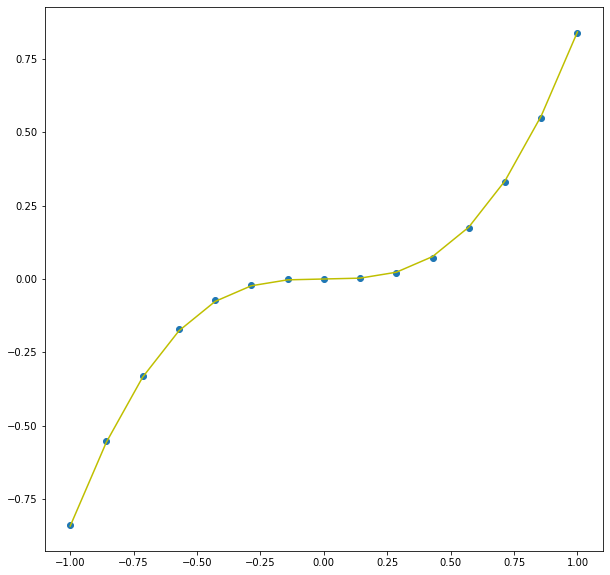

In [10]:
plt.figure(figsize=(10,10))
plt.plot(xx,[f(x) for x in xx],c='y')
plt.scatter(xx,y)
plt.show()

In [11]:
for n in [10,20,40,100,200]:
  xx=np.linspace(-1,1,n)
  y=l2_linear_approx(f,xx)

  print("node no: %d\tmax deviation: %f"%(n,np.max(np.abs(np.array(y)-np.array([f(x) for x in xx])))))


node no: 10	max deviation: 0.013099
node no: 20	max deviation: 0.002959
node no: 40	max deviation: 0.000703
node no: 100	max deviation: 0.000109
node no: 200	max deviation: 0.000027


### 2) FEM for Poisson with Dirichlet boundary conditions

As mentioned in the introduction, the FEM method is conceptually very similar to the pure projection, but now the inner product is defined with the a(.,.) bilinear form. 

The first step is to write out the weak form of the Poisson equation. Using the observation from class regarding partial intgeration and boundary conditions, 

$a(u,v) = \int_0^1 u'(x) v'(x)~dx$ and

$L(v)=\int_0^1 f(x) v(x)~dx$

(recall that the Poisson equation reads as $-u''(x) = f(x)$ and the BC are $u(0)=u(1)=0$)

Thus we proceed in a very similar manner as for the L2 projection. The only thing to note that is when assemblying the system to solve, we do not consider the 'border nodes' - this impicitly enforces the Dirichlet boundary condition.

Also observe that we use second order shape functions since the Poisson equaiton involves second derivatives. We require our approximate soliution to be continuous, otherwise the trick with partial integration (which is an essential step in obtaining an unique solution) fails.

In [12]:
def assembly_continuous(f,mesh):
  """
  Assembly algorithm for 1D applications, where the border nodes of the mesh are 'glued together' enforcing continuity
  Arguments: f function and the mesh: a list of elements
  returns A and b as the assembled system which then can be used for later computations 
  """

  
  n=len(mesh)
  local_shape_no=np.array([mesh[i].get_local_shape_no() for i in range(n)])
  m=np.sum(local_shape_no)

  _A=np.zeros((m-n+1,m-n+1),float)
  _b=np.zeros(m-n+1,float)

  loc2glob = lambda x: np.sum(local_shape_no[:x[0]])+x[1]-x[0] # x is a 2-tuple of indices (global,local) 

  for i in range(n):
    for j in range(local_shape_no[i]):
      _b[loc2glob((i,j))]+=mesh[i].integrate_vector(j,f)
      for k in range(local_shape_no[i]):
        _A[loc2glob((i,j)),loc2glob((i,k))]+=mesh[i].integrate_matrix(j,k)

 

                                                                                 

  return _A,_b

In [13]:
def fem_poisson(f,xx):
  """
  function for FEM solution of the Poisson equation: f + u'' = 0 
  function f is the source term
  xx is supposed to be the ordered list of mesh points

  returns u approximating function evaluated in the mesh points - right endpoint approximation, when possible

  The solution uses second order Lagrange elements.
  """

  mesh=[poisson_1d_element(xx[i],xx[i+1],2) for i in range(len(xx)-1)]

  _A,_b=assembly_continuous(f,mesh) # benefits of modular coding :P

  A=_A[1:-1,1:-1] # leave out nodes at border: enforce Dirichlet
  b=_b[1:-1]

  yy=np.linalg.solve(A,b)

  return [0]+[yy[2*j] for j in range(len(mesh)-1)] +[0] # we utilize that the Lagrange basis is nodal


In [14]:
f=lambda x: 1.*(x<0.6)*(x>0.4)

In [16]:
f_exact=lambda x: (x<0.4)*0.1*x-(x>=0.4)*(x<0.6)*((x-0.5)**2-0.045)+(x>0.6)*(1-x)*0.1 # exact solution

In [21]:
xx=np.linspace(0,1,20)
xxx=np.linspace(0,1,10)

In [22]:
y=fem_poisson(f,xx)

In [23]:
yy=fem_poisson(f,xxx)

The solutions are both quite close to the exact function.

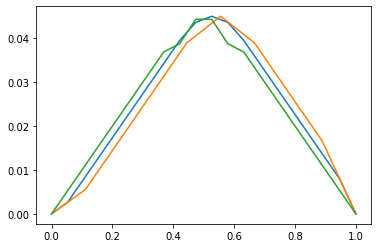

In [24]:
plt.figure()
plt.plot(xx,y)
plt.plot(xxx,yy)
plt.plot(xx,[f_exact(x) for x in xx])
plt.show()


# **Summary, discussion**

Both methods work as expected.

The soluiton of the Poisson equation with FEM takes surprisingly long time. Most probably, I should have computed the integrals only once and store them (at least for the matrix elements).

The FEM part may be a bit less documented, but I hope it's ok since this was not a compusory assignment.